OUTLIER DETECTION AND CLEANING - IO PRESSURE ANALYSIS

📊 Processing IOWait:
  🔍 IOPRESSURE:
    ✅ No outliers detected
  🔍 BASELINE:
    ✅ Cleaned 137 outliers across all CPU cores

📊 Processing IRQ:
  🔍 IOPRESSURE:
    ✅ Cleaned 153 outliers across all CPU cores
  🔍 BASELINE:
    ✅ Cleaned 264 outliers across all CPU cores

📊 Processing System:
  🔍 IOPRESSURE:
    ✅ No outliers detected
  🔍 BASELINE:
    ✅ Cleaned 116 outliers across all CPU cores

📊 Processing User:
  🔍 IOPRESSURE:
    ✅ Cleaned 272 outliers across all CPU cores
  🔍 BASELINE:
    ✅ Cleaned 238 outliers across all CPU cores

📊 Processing Utilization:
  🔍 IOPRESSURE:
    ✅ Cleaned 290 outliers across all CPU cores
  🔍 BASELINE:
    ✅ Cleaned 264 outliers across all CPU cores

COMPREHENSIVE IO PRESSURE ANALYSIS

🔄 Analyzing IOWait...


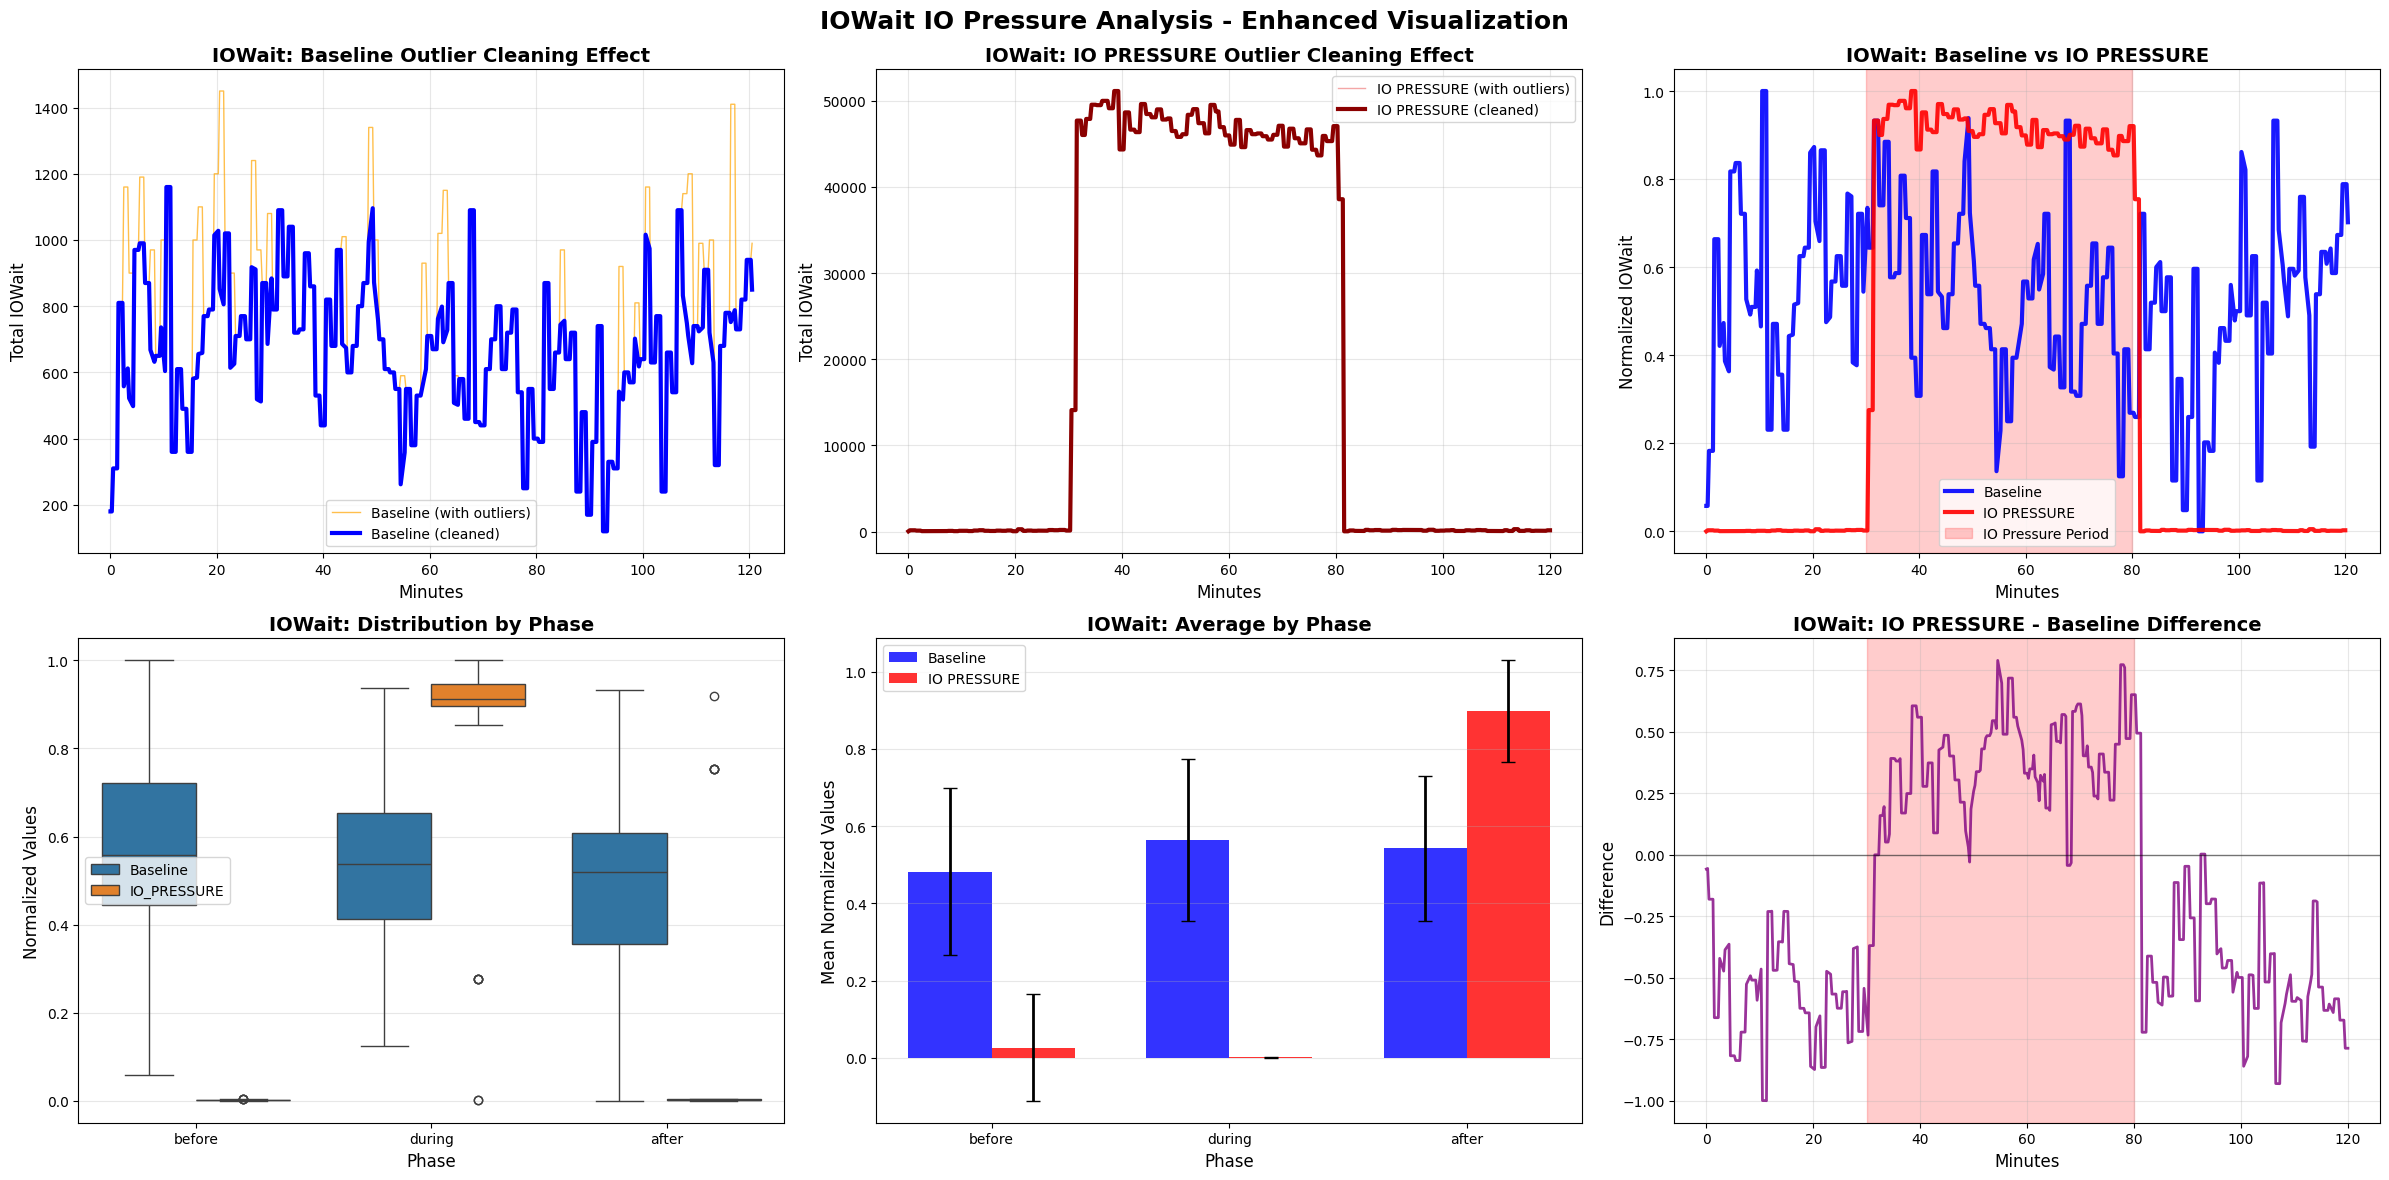


IOWAIT - IO PRESSURE ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.4818  0.2161  0.0000  0.9327
before  0.5646  0.2093  0.0577  1.0000
during  0.5425  0.1884  0.1250  0.9385

📊 IO PRESSURE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.0265  0.1376  0.0000  0.9203
before  0.0015  0.0010  0.0000  0.0047
during  0.8976  0.1317  0.0018  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 29.48, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-21.90, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= 22.51, p=  0.0000 (✅ SIGNIFICANT)

📈 IO PRESSURE IMPACT (% CHANGE):
  BEFORE  :  -99.74% (↘️ DECREASE)
  DURING  :  +65.47% (↗️ INCREASE)
  AFTER   :  -94.50% (↘️ DECREASE)

🔄 Analyzing IRQ...


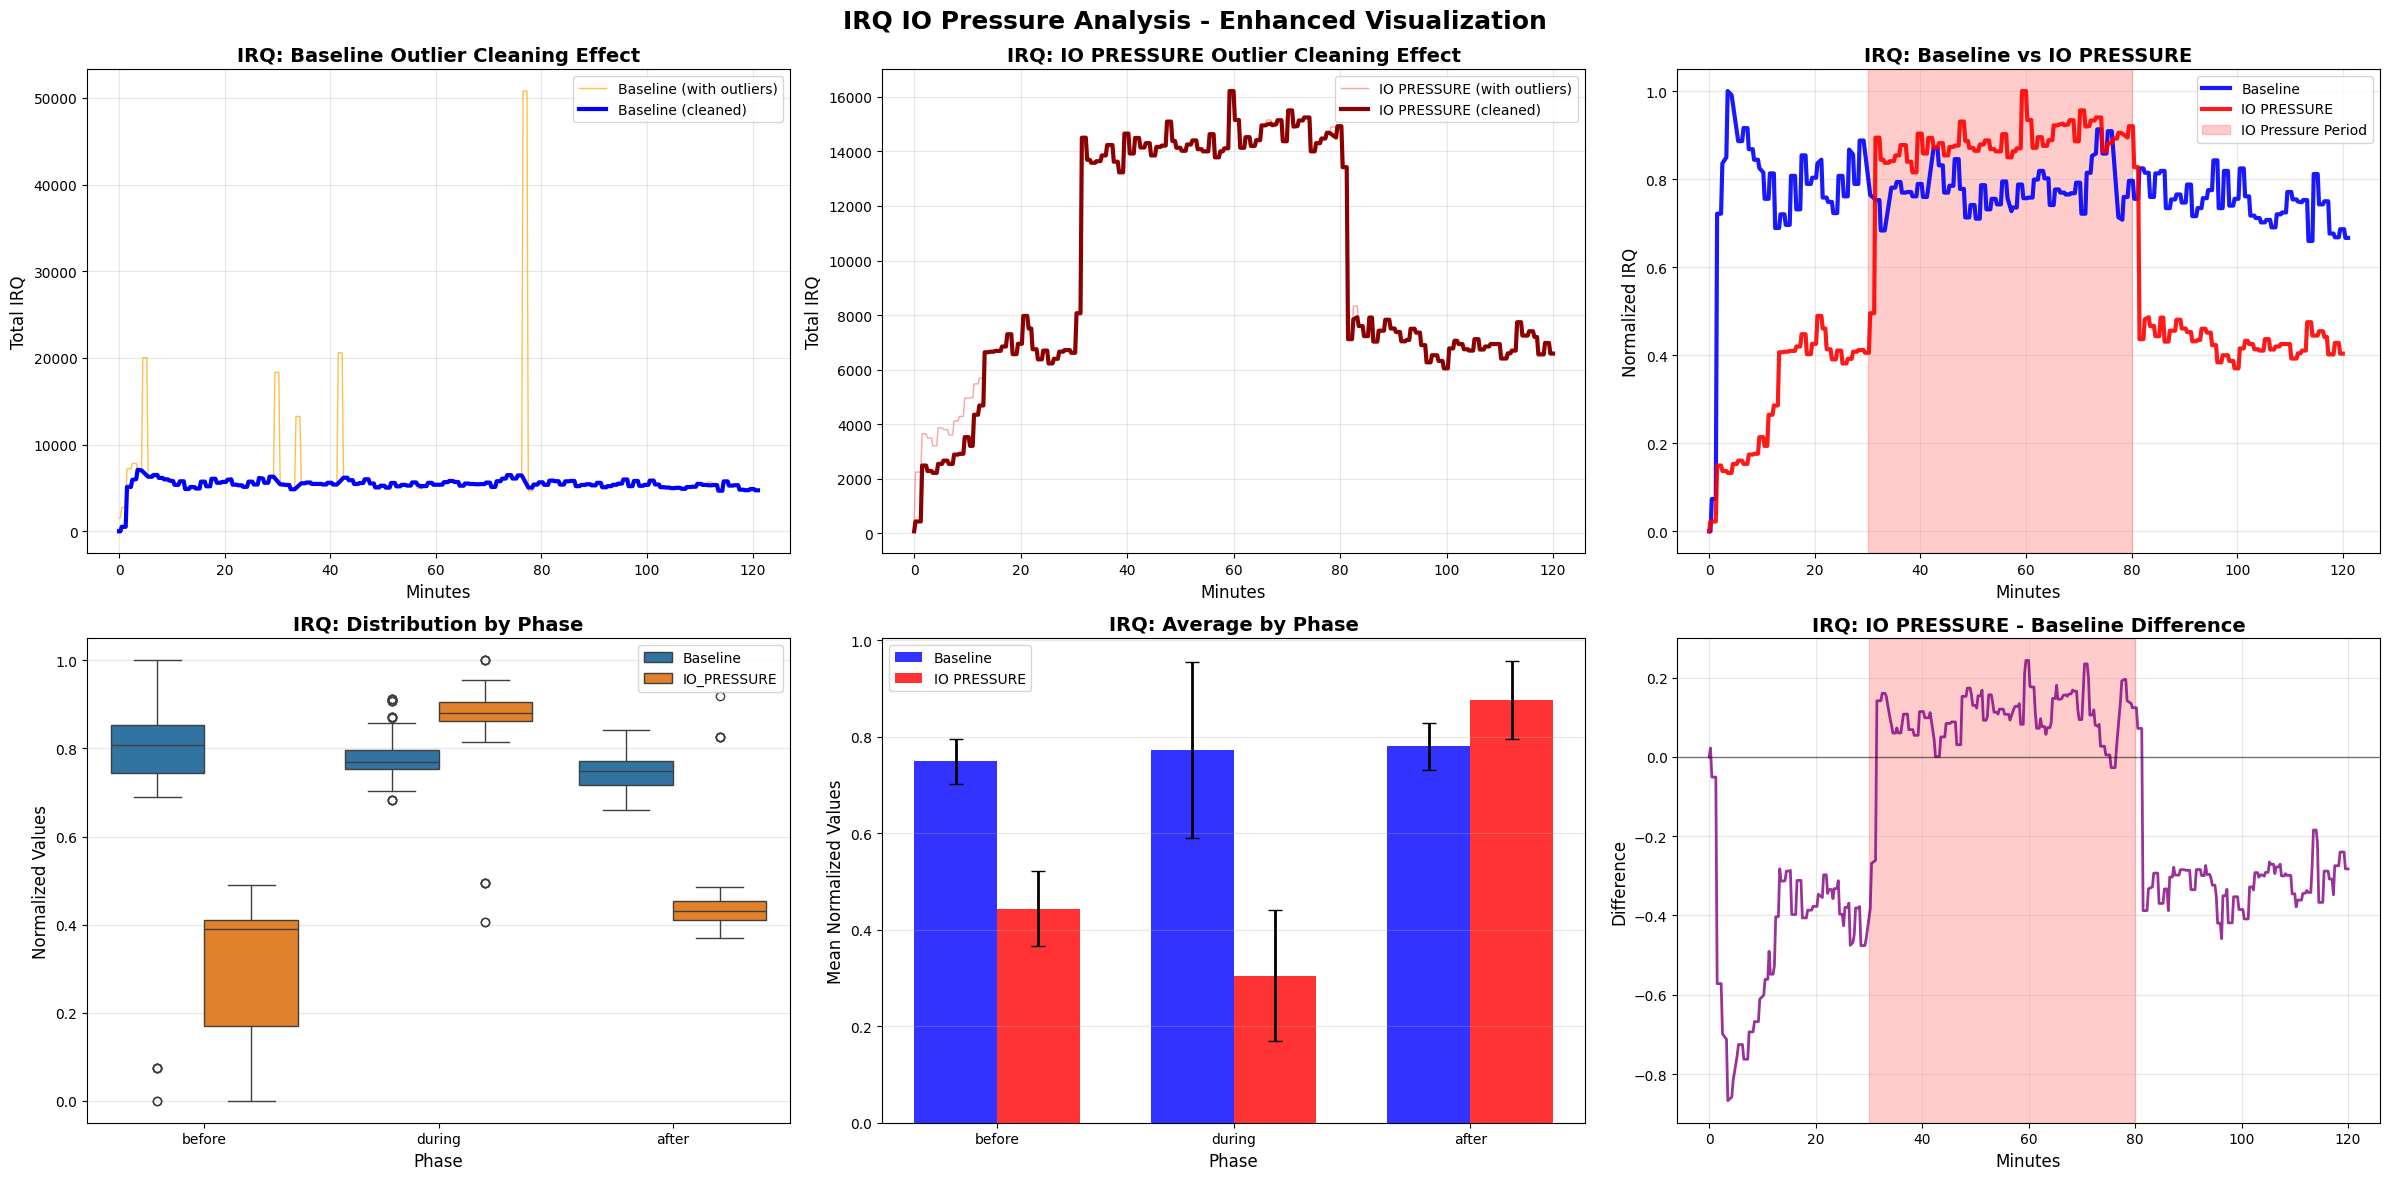


IRQ - IO PRESSURE ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.7492  0.0465  0.6594  0.8425
before  0.7721  0.1819  0.0000  1.0000
during  0.7796  0.0481  0.6833  0.9130

📊 IO PRESSURE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.4435  0.0778  0.3701  0.9200
before  0.3048  0.1351  0.0000  0.4892
during  0.8756  0.0802  0.4055  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 22.59, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-14.54, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= 43.05, p=  0.0000 (✅ SIGNIFICANT)

📈 IO PRESSURE IMPACT (% CHANGE):
  BEFORE  :  -60.52% (↘️ DECREASE)
  DURING  :  +12.30% (↗️ INCREASE)
  AFTER   :  -40.81% (↘️ DECREASE)

🔄 Analyzing System...


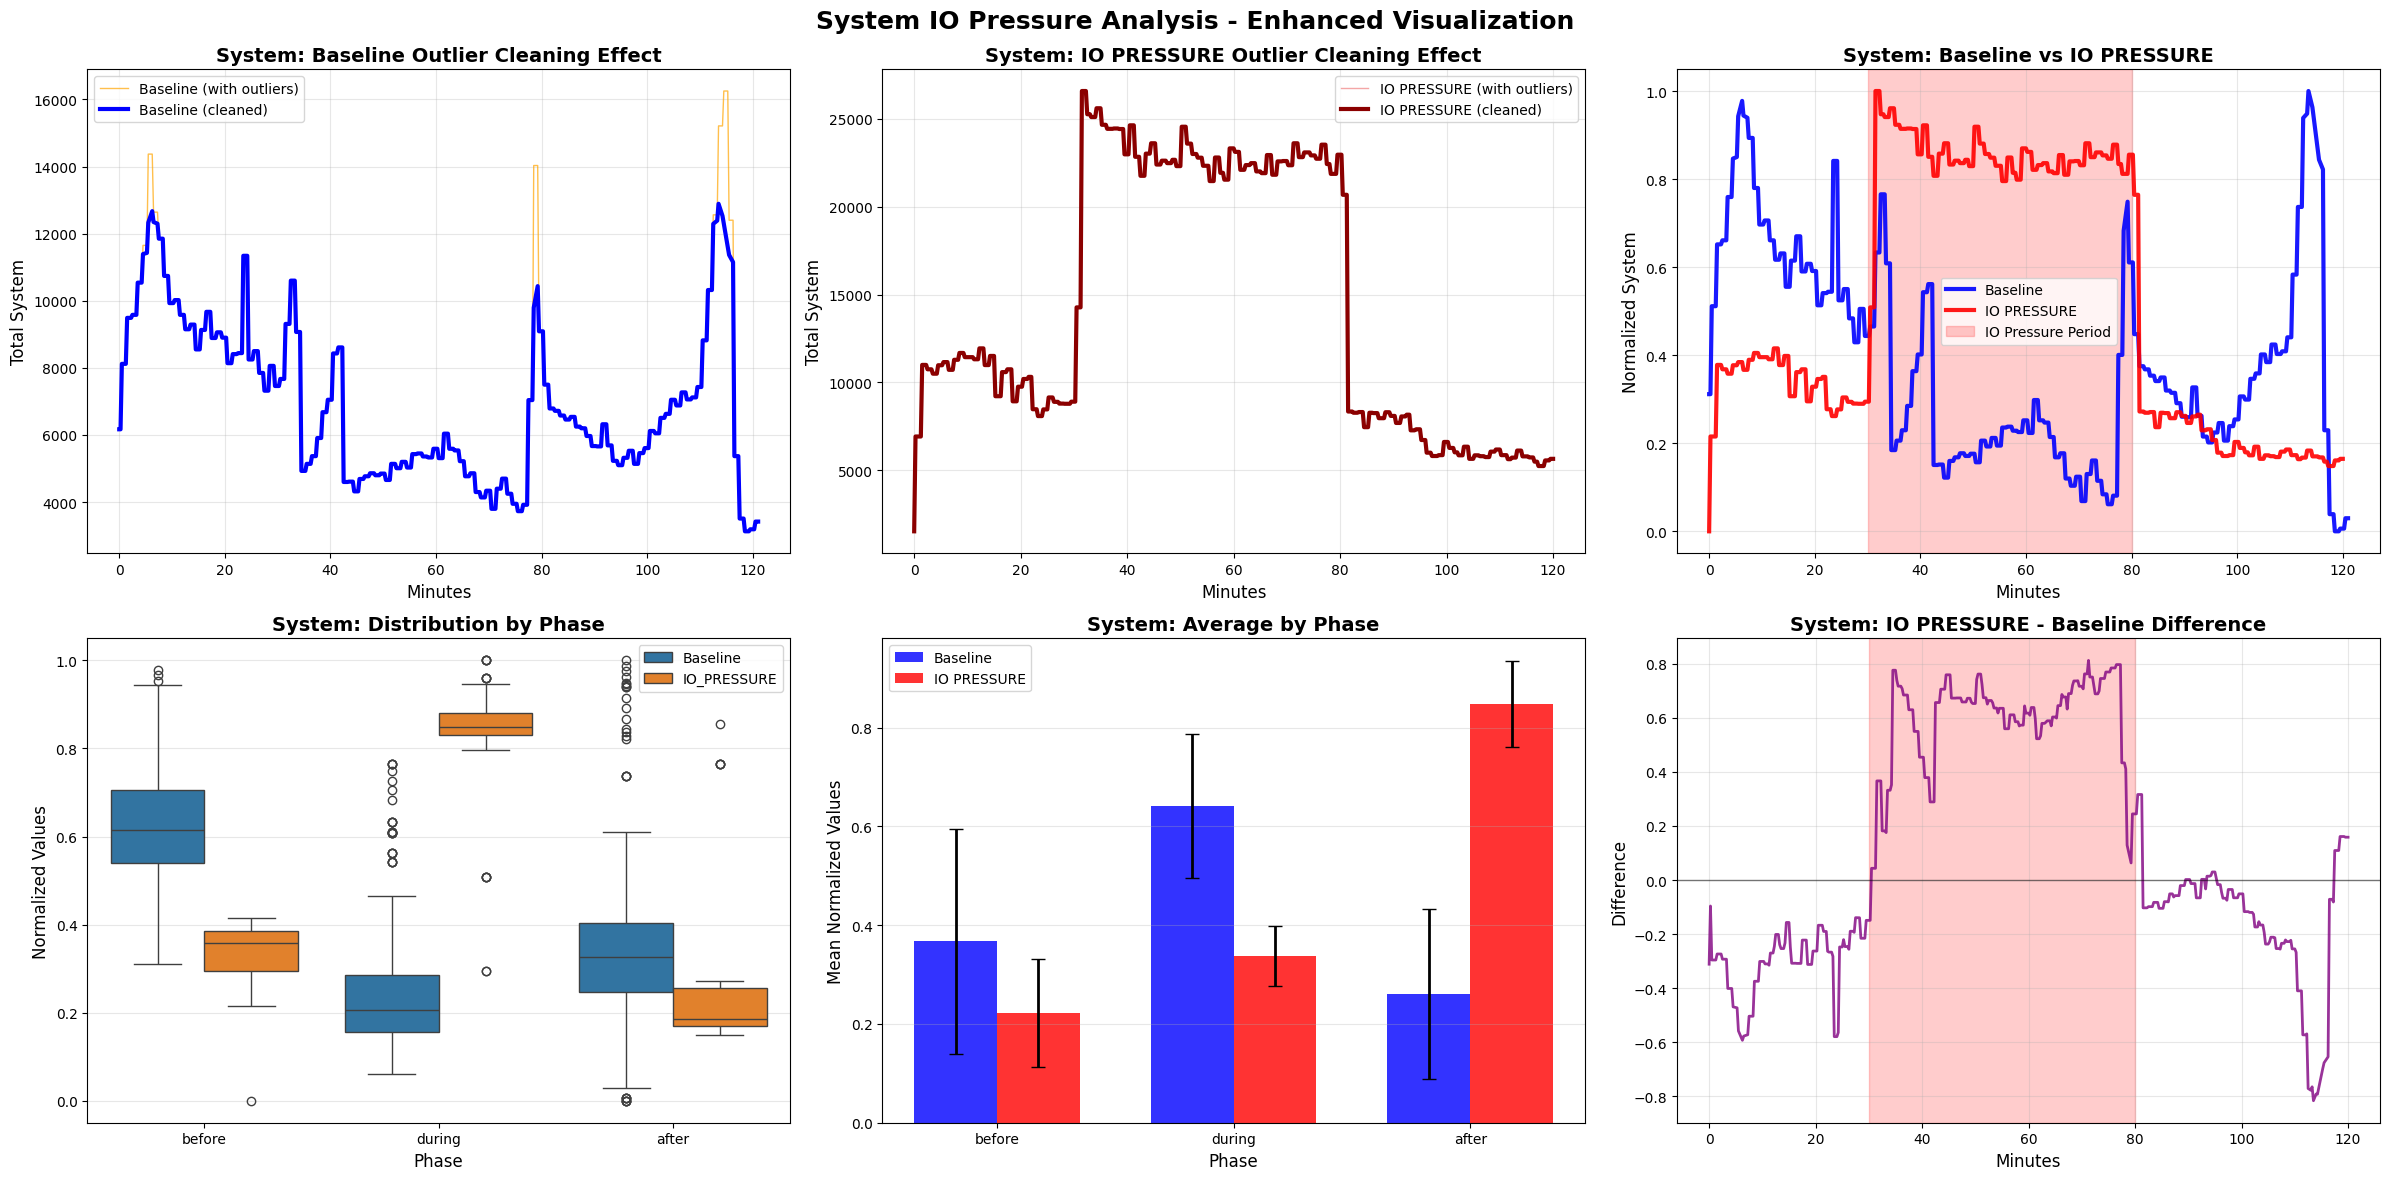


SYSTEM - IO PRESSURE ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3673  0.2274  0.0000  1.0000
before  0.6419  0.1458  0.3115  0.9775
during  0.2605  0.1725  0.0615  0.7654

📊 IO PRESSURE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.2221  0.1093  0.1482  0.8554
before  0.3376  0.0605  0.0000  0.4155
during  0.8478  0.0862  0.2944  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= 21.11, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=-43.17, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=  7.29, p=  0.0000 (✅ SIGNIFICANT)

📈 IO PRESSURE IMPACT (% CHANGE):
  BEFORE  :  -47.40% (↘️ DECREASE)
  DURING  : +225.47% (↗️ INCREASE)
  AFTER   :  -39.53% (↘️ DECREASE)

🔄 Analyzing User...


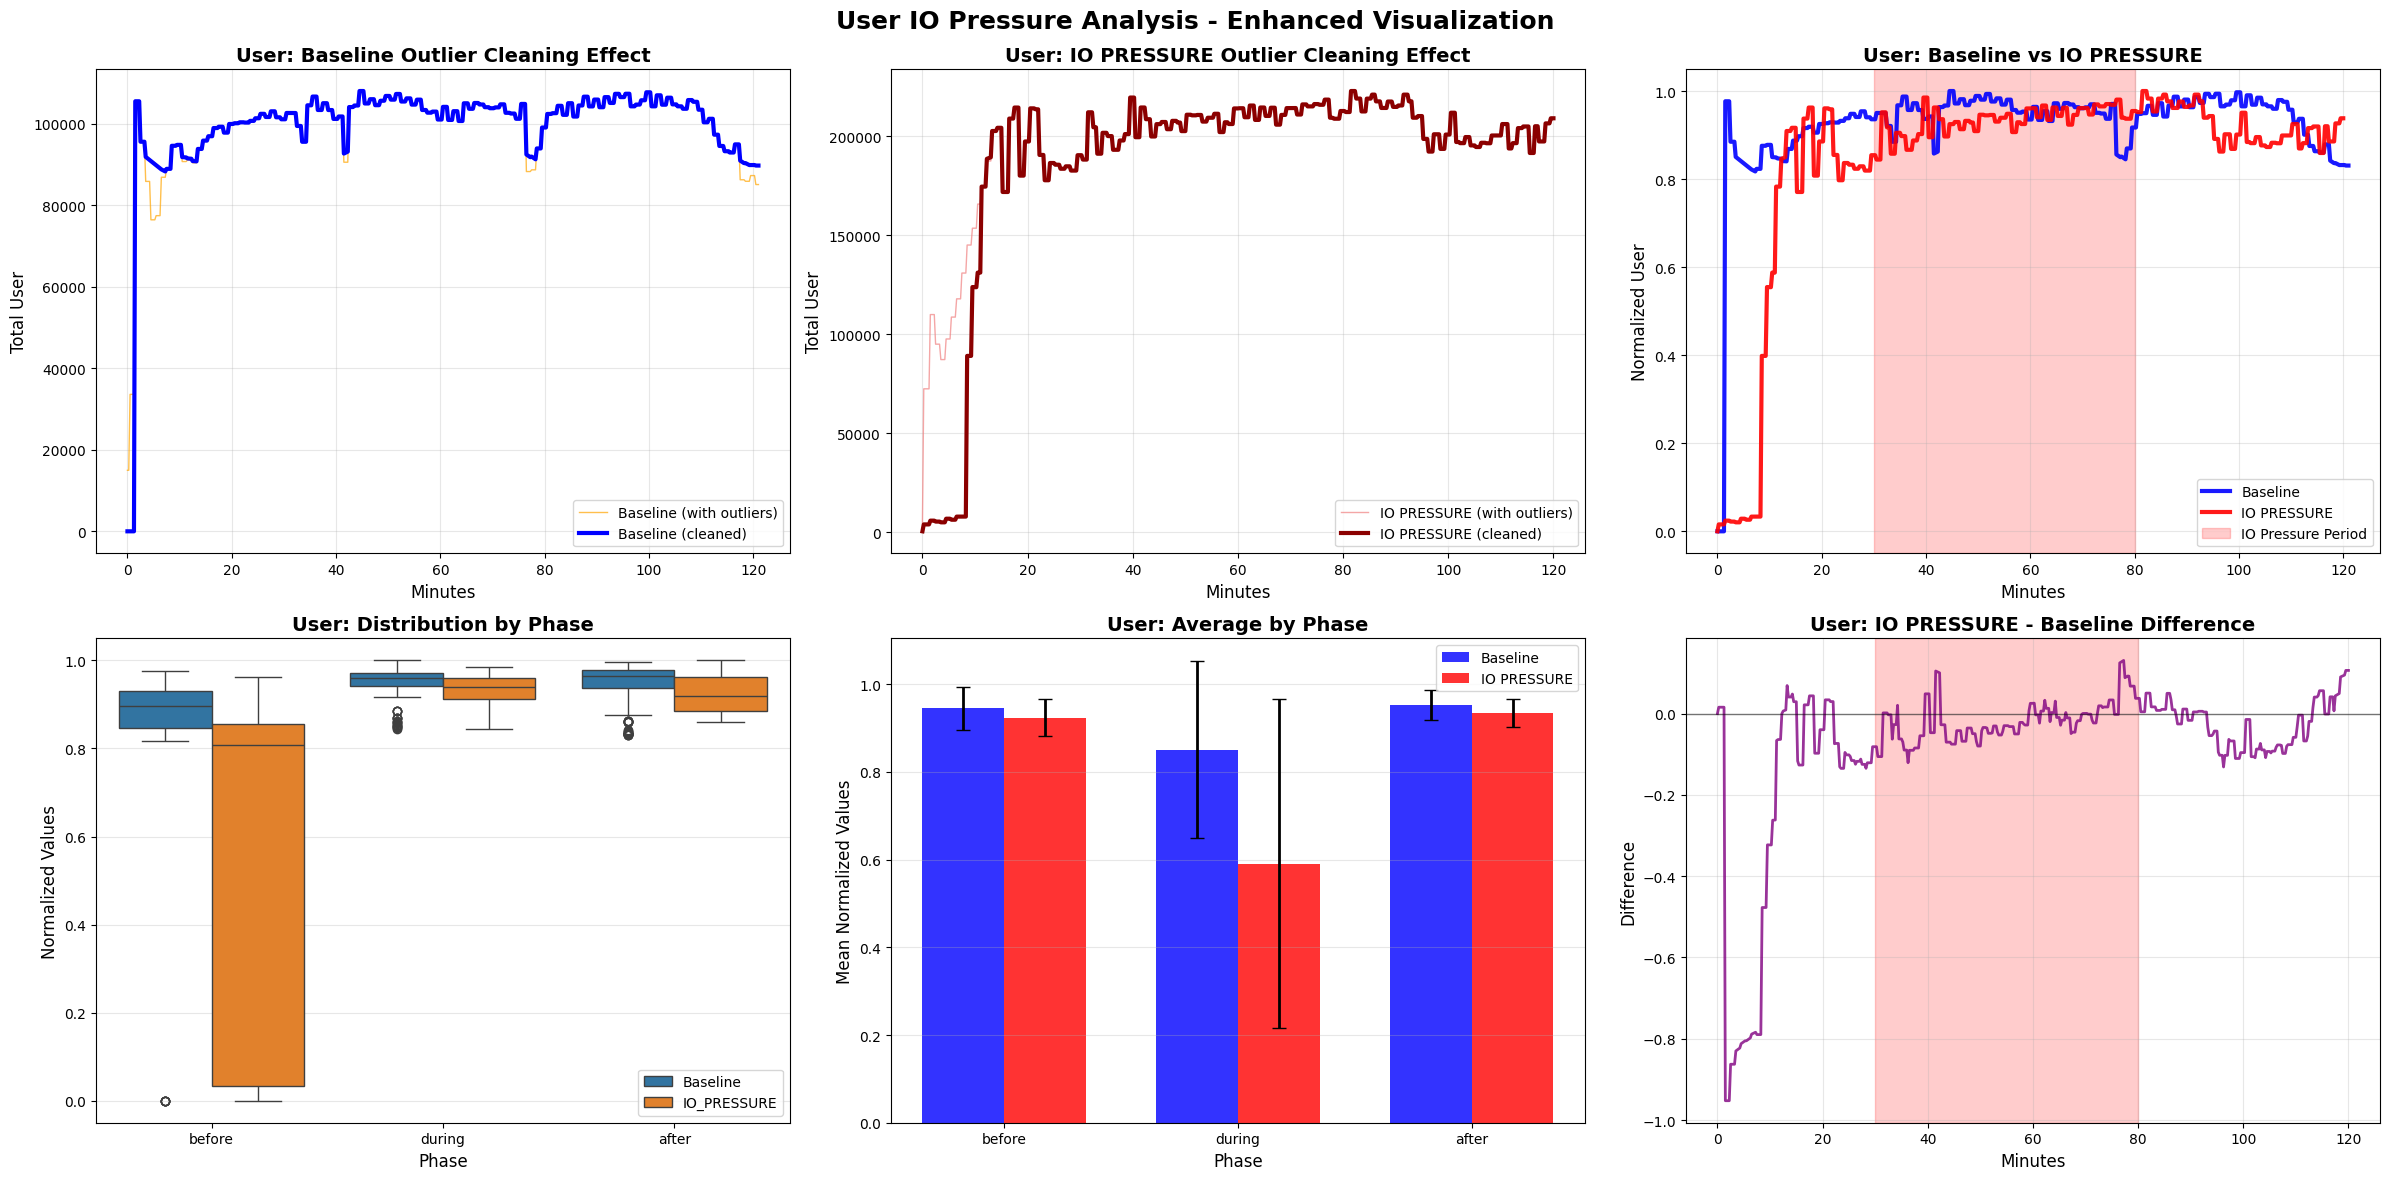


USER - IO PRESSURE ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9451  0.0493  0.8307  0.9971
before  0.8510  0.2008  0.0000  0.9767
during  0.9519  0.0346  0.8450  1.0000

📊 IO PRESSURE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9235  0.0419  0.8592  1.0000
before  0.5906  0.3752  0.0000  0.9625
during  0.9333  0.0320  0.8443  0.9852

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  6.70, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=  5.57, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=  4.24, p=  0.0000 (✅ SIGNIFICANT)

📈 IO PRESSURE IMPACT (% CHANGE):
  BEFORE  :  -30.60% (↘️ DECREASE)
  DURING  :   -1.95% (↘️ DECREASE)
  AFTER   :   -2.28% (↘️ DECREASE)

🔄 Analyzing Utilization...


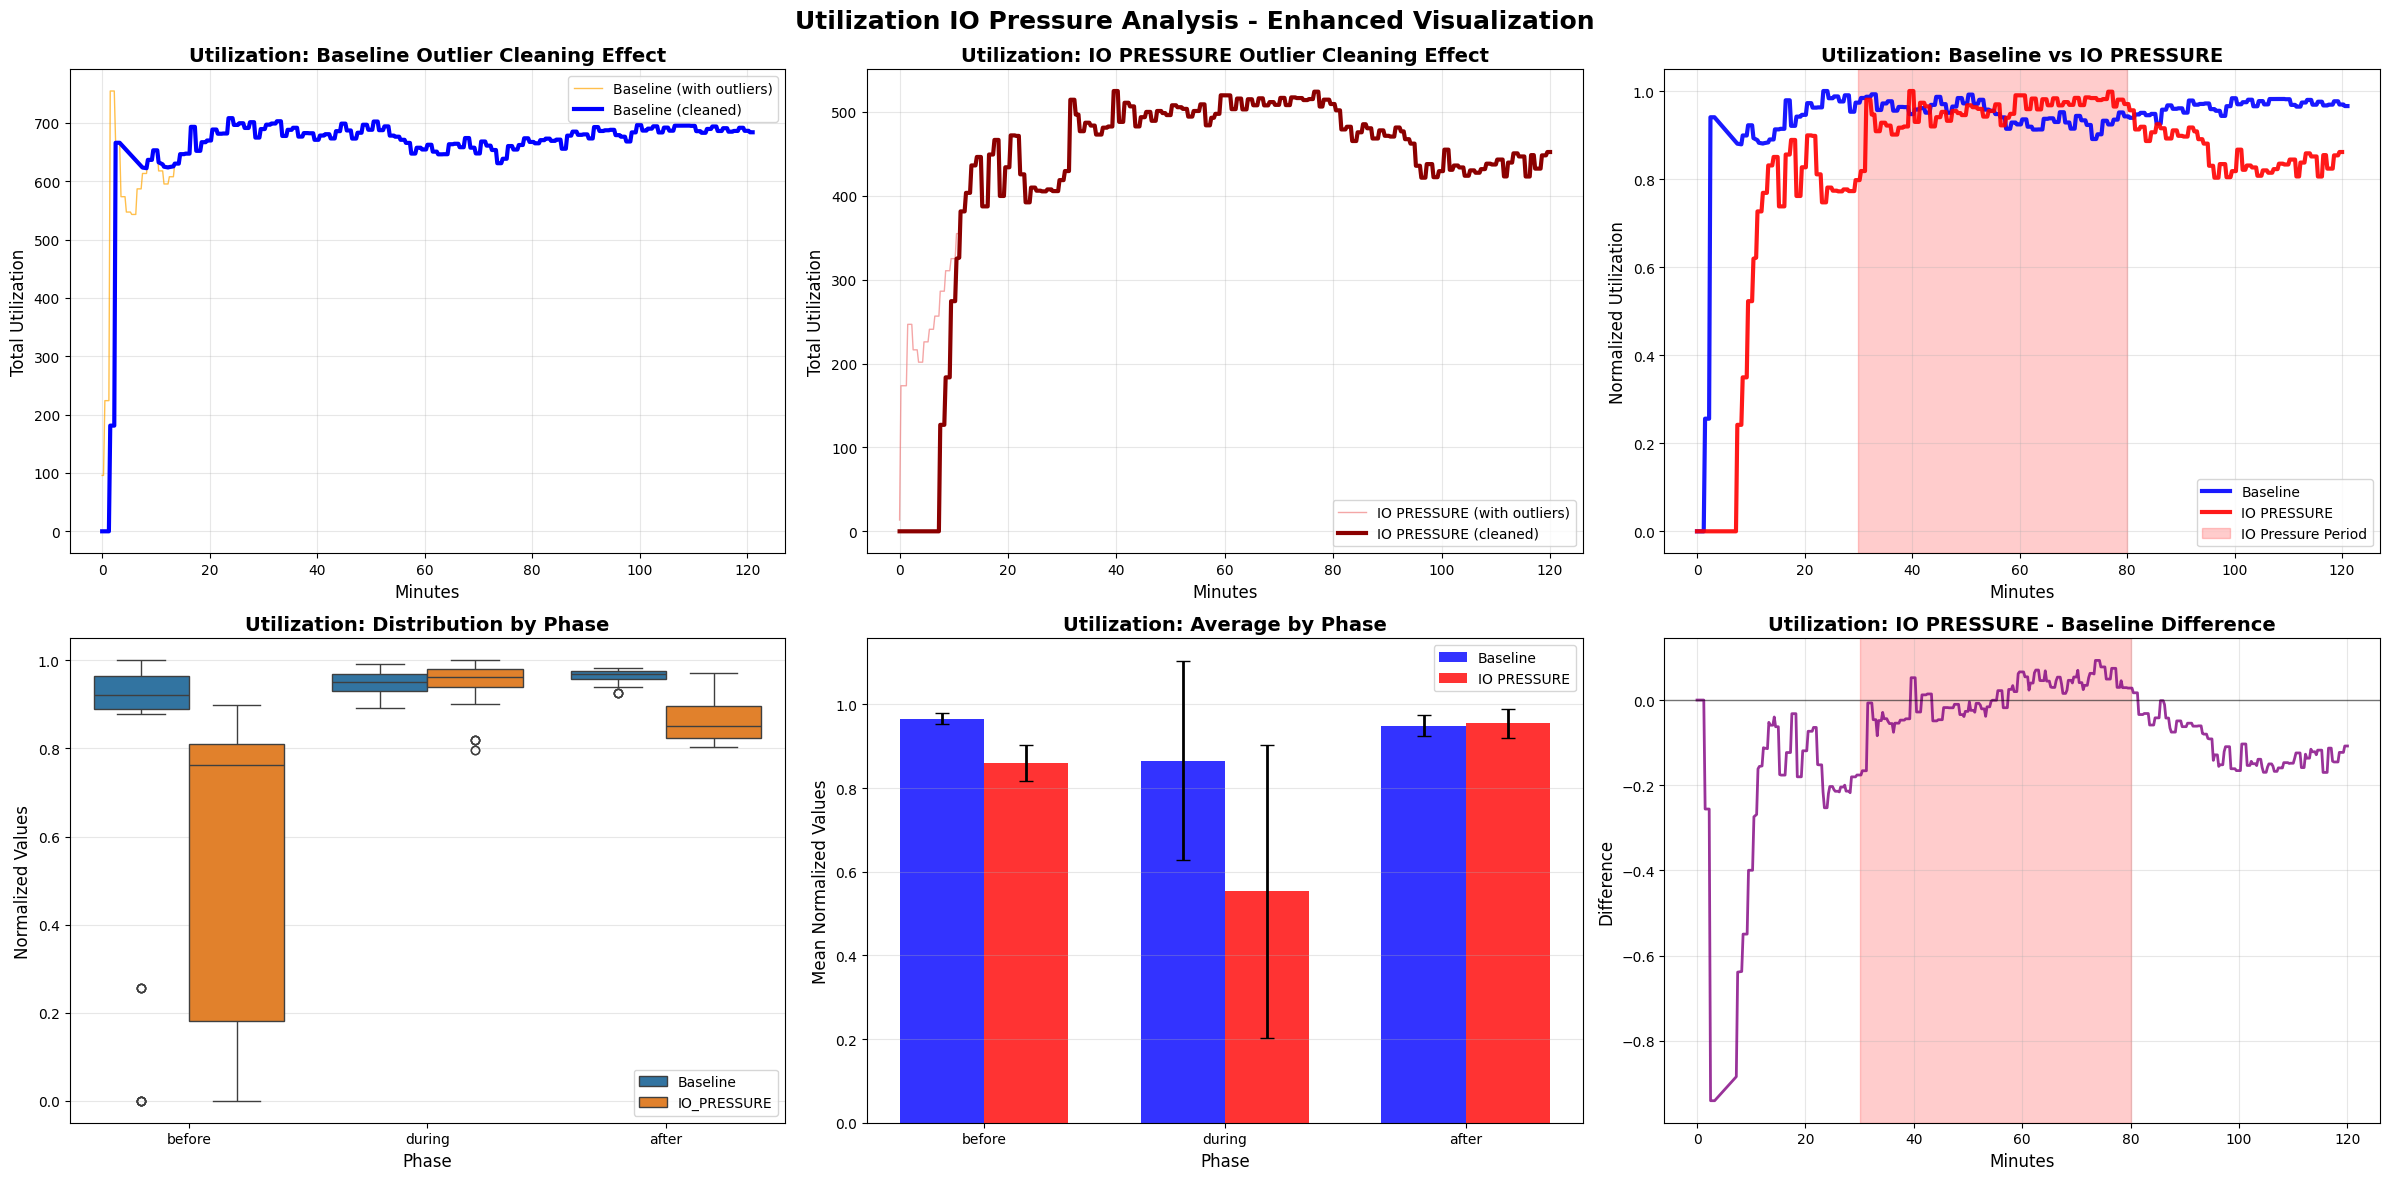


UTILIZATION - IO PRESSURE ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std    min     max
phase                                
after   0.9655  0.0134  0.926  0.9836
before  0.8658  0.2368  0.000  1.0000
during  0.9489  0.0247  0.891  0.9925

📊 IO PRESSURE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.8597  0.0421  0.8032  0.9705
before  0.5537  0.3501  0.0000  0.8992
during  0.9543  0.0353  0.7976  1.0000

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  8.09, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= -1.75, p=  0.0809 (❌ NOT SIGNIFICANT)
  AFTER   : t= 30.61, p=  0.0000 (✅ SIGNIFICANT)

📈 IO PRESSURE IMPACT (% CHANGE):
  BEFORE  :  -36.05% (↘️ DECREASE)
  DURING  :   +0.56% (↗️ INCREASE)
  AFTER   :  -10.96% (↘️ DECREASE)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats

# Load all datasets
df_iowait = pd.read_csv("cpu_iowait.csv")
df_cpu_irq = pd.read_csv("cpu_irq.csv")
df_system_msec = pd.read_csv("cpu_system_msec.csv")
df_user_msec = pd.read_csv("cpu_user_msec.csv")
df_cpu_util = pd.read_csv("cpu_util_per.csv")

df_baseline_iowait = pd.read_csv("../../baseline/cpu related/cpu_iowait.csv")
df_baseline_irq = pd.read_csv("../../baseline/cpu related/cpu_irq.csv")
df_baseline_system_msec = pd.read_csv("../../baseline/cpu related/cpu_system_msec.csv")
df_baseline_user_msec = pd.read_csv("../../baseline/cpu related/cpu_user_msec.csv")
df_baseline_util_per = pd.read_csv("../../baseline/cpu related/cpu_util_per.csv")

# Add source labels
df_iowait["source"] = "IOPRESSURE"
df_cpu_irq["source"] = "IOPRESSURE"
df_system_msec["source"] = "IOPRESSURE"
df_user_msec["source"] = "IOPRESSURE"
df_cpu_util["source"] = "IOPRESSURE"

df_baseline_iowait["source"] = "BASELINE"
df_baseline_irq["source"] = "BASELINE"
df_baseline_system_msec["source"] = "BASELINE"
df_baseline_user_msec["source"] = "BASELINE"
df_baseline_util_per["source"] = "BASELINE"

# Convert to datetime
df_iowait["Time"] = pd.to_datetime(df_iowait["Time"])
df_cpu_irq["Time"] = pd.to_datetime(df_cpu_irq["Time"])
df_system_msec["Time"] = pd.to_datetime(df_system_msec["Time"])
df_user_msec["Time"] = pd.to_datetime(df_user_msec["Time"])
df_cpu_util["Time"] = pd.to_datetime(df_cpu_util["Time"])

df_baseline_iowait["Time"] = pd.to_datetime(df_baseline_iowait["Time"])
df_baseline_irq["Time"] = pd.to_datetime(df_baseline_irq["Time"])
df_baseline_system_msec["Time"] = pd.to_datetime(df_baseline_system_msec["Time"]) 
df_baseline_user_msec["Time"] = pd.to_datetime(df_baseline_user_msec["Time"])
df_baseline_util_per["Time"] = pd.to_datetime(df_baseline_util_per["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_iowait["Time"].min() - df_iowait["Time"].min()
df_iowait["Time"] += time_offset
df_cpu_irq["Time"] += time_offset
df_system_msec["Time"] += time_offset
df_user_msec["Time"] += time_offset
df_cpu_util["Time"] += time_offset

# Convert timeline to minutes 
all_dfs = [
    df_iowait, df_cpu_irq, df_system_msec, df_user_msec, df_cpu_util,
    df_baseline_iowait, df_baseline_irq, df_baseline_system_msec, 
    df_baseline_user_msec, df_baseline_util_per
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# ORIGINAL DATASETS DICTIONARY 
original_datasets = {
    'IOWait': {'iopressure': df_iowait, 'baseline': df_baseline_iowait},
    'IRQ': {'iopressure': df_cpu_irq, 'baseline': df_baseline_irq},
    'System': {'iopressure': df_system_msec, 'baseline': df_baseline_system_msec},
    'User': {'iopressure': df_user_msec, 'baseline': df_baseline_user_msec},
    'Utilization': {'iopressure': df_cpu_util, 'baseline': df_baseline_util_per}
}

# OUTLIER DETECTION AND CLEANING
def remove_outliers_comprehensive(df, method='iqr', threshold=1.5):
    df_clean = df.copy()
    cpu_cols = [col for col in df.columns if col.startswith('cpu')]
    outlier_stats = {}
    
    if method == 'iqr':
        for col in cpu_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
            
            outlier_stats[col] = {
                'count': outlier_mask.sum(),
                'percentage': (outlier_mask.sum() / len(df[col])) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
            
            # Set outliers to NaN and interpolate
            df_clean.loc[outlier_mask, col] = np.nan
            df_clean[col] = df_clean[col].interpolate(method='linear')
                
    return df_clean, outlier_stats

# APPLY OUTLIER CLEANING
print("=" * 80)
print("OUTLIER DETECTION AND CLEANING - IO PRESSURE ANALYSIS")
print("=" * 80)

datasets_clean = {}
all_outlier_stats = {}

for dataset_name, dataset_pair in original_datasets.items():
    print(f"\n📊 Processing {dataset_name}:")
    
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        print(f"  🔍 {source_type.upper().replace('_', ' ')}:")
        df_clean, stats = remove_outliers_comprehensive(df, method='iqr', threshold=1.5)
        datasets_clean[dataset_name][source_type] = df_clean
        all_outlier_stats[dataset_name][source_type] = stats
        
        # Print outlier summary
        total_outliers = sum([s['count'] for s in stats.values()])
        if total_outliers > 0:
            print(f"    ✅ Cleaned {total_outliers} outliers across all CPU cores")
        else:
            print(f"    ✅ No outliers detected")

# NORMALIZATION FUNCTION
def normalize_df(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# ADD PHASE COLUMN 
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# ANALYSIS AND PLOT FUNCTION
def analyze_and_plot_dataset_wide(dataset_name, iopressure_df, baseline_df, delay_minutes, duration_minutes):
    cpu_cols = [col for col in iopressure_df.columns if col.startswith('cpu')]
    
    iopressure_norm = normalize_df(iopressure_df, cpu_cols)
    baseline_norm = normalize_df(baseline_df, cpu_cols)
    
    # Calculate cumulative metrics
    iopressure_df['Total'] = iopressure_df[cpu_cols].sum(axis=1)
    baseline_df['Total'] = baseline_df[cpu_cols].sum(axis=1)
    
    # Normalize totals
    iopressure_norm['Total'] = (iopressure_df['Total'] - iopressure_df['Total'].min()) / (iopressure_df['Total'].max() - iopressure_df['Total'].min())
    baseline_norm['Total'] = (baseline_df['Total'] - baseline_df['Total'].min()) / (baseline_df['Total'].max() - baseline_df['Total'].min())
    
    # Add phase information
    iopressure_norm = add_phase_column(iopressure_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis
    stats_baseline = baseline_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    stats_iopressure = iopressure_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm['Total'],
        'IO_PRESSURE': iopressure_norm['Total'],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': iopressure_norm['Total'] - baseline_norm['Total']
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['IO_PRESSURE'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        iopressure_mean = stats_iopressure.loc[phase, 'mean']
        impact[phase] = ((iopressure_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # PLOTTING
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline outlier cleaning effect
    plt.subplot(2, 3, 1)
    original_baseline = original_datasets[dataset_name]['baseline']
    
    plt.plot(original_baseline['Minutes'], original_baseline[cpu_cols].sum(axis=1), 
             label='Baseline (with outliers)', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df['Minutes'], baseline_df['Total'], 
             label='Baseline (cleaned)', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. IO PRESSURE outlier cleaning effect
    plt.subplot(2, 3, 2)
    original_iopressure = original_datasets[dataset_name]['iopressure']
    
    plt.plot(original_iopressure['Minutes'], original_iopressure[cpu_cols].sum(axis=1), 
             label='IO PRESSURE (with outliers)', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(iopressure_df['Minutes'], iopressure_df['Total'], 
             label='IO PRESSURE (cleaned)', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: IO PRESSURE Outlier Cleaning Effect', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm['Total'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(iopressure_norm['Minutes'], iopressure_norm['Total'], 
             label='IO PRESSURE', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="IO Pressure Period")
    plt.title(f"{dataset_name}: Baseline vs IO PRESSURE", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {dataset_name}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'IO_PRESSURE', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_iopressure['mean'], width, label='IO PRESSURE', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_iopressure['mean'], yerr=stats_iopressure['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: IO PRESSURE - Baseline Difference', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} IO Pressure Analysis - Enhanced Visualization', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # Print statistical results
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - IO PRESSURE ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 IO PRESSURE STATISTICS BY PHASE:")
    print(stats_iopressure.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 IO PRESSURE IMPACT (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_iopressure': stats_iopressure,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined
    }

# RUN ANALYSIS FOR ALL DATASETS
print(f"\n{'='*80}")
print("COMPREHENSIVE IO PRESSURE ANALYSIS")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name}...")
    
    iopressure_clean = datasets_clean[dataset_name]['iopressure']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_dataset_wide(
        dataset_name, 
        iopressure_clean, 
        baseline_clean, 
        delay, 
        duration
    )
